# Valves design for adaptive air cushion

The following notebook was written in order to help design of the adaptive valve for air cushion. The goal is to compute vent hole area in function of displacement of mechanical actuator as well as verify functional properties.

![](images/valve_design_conconcept_1.png)

In [1]:
#import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Video

### Define parameters for oryginal and new shape of vent holes

In [2]:
# INPUTS
# all values in units of [mm] or 10e-2[m]
original_r = 10 # radius of original round vent hole
r = 15 # slot radius
slot_width = 30 # slot width - arc center to center
#Set value to 0 in order to change vent hole shape to round

![](images/slot.png)

### Compare old and new vent holes area

In [3]:
original_vent_hole_area = round(math.pi*original_r**2, 2)
slot_area = round(math.pi*r**2 + (slot_width * (2*r)), 2)
slot_ratio = round(slot_area / original_vent_hole_area, 2)
print('Original round vent hole area: {} mm2\nSlot vent hole area: {} mm2'.format(original_vent_hole_area, slot_area))
print('Vent valve area ratio: {}'.format(slot_ratio))

Original round vent hole area: 314.16 mm2
Slot vent hole area: 1606.86 mm2
Vent valve area ratio: 5.11


### Compute area of circle slice
![](images/circle.png)

In [4]:
# valve position from edge
# could be in range from 0 (completely open valve)
# to 2*r (completely colsed valve)
val_pos = 10 # [mm]

try:
    if not (0 < val_pos < 2*r):
        raise ValueError("ERROR! Valve position must be in range from 0 to {}!"
                         .format(2*r))
except ValueError as e:
    print(e)

# compute height of inner triangle - valve position from circle center
if 0 < val_pos <= r:
    h = r - val_pos
elif r < val_pos < 2*r:
    h = val_pos - r

# print circle data
print('CIRCLE DATA:')
print('Circle diameter: {} mm\nCircle area: {} mm2\n'.format(2*r, round(math.pi*r**2),2))
# compute dimensions of inner triangle 
a_2 = math.sqrt(r**2 - h**2) # compute side of the inner triangle 
circle_chord = a_2*2 # compute circle chord
print('COMPUTED DATA:')
print('Valve position from edge: {} mm'.format(val_pos))
print('Length of circle chord: {} mm'.format(round(circle_chord)))
# compute vertex angle
alpha = 2*math.asin(a_2/r)*(180/math.pi)
print('Arc central angle: {} deg'.format(round(alpha, 2)))
# compute triangle area
triangle_area = 0.5*(2*a_2 * h)
# compute circle slice area
circle_slice_area = ((alpha/360)*math.pi*r**2) - triangle_area
print('Area of circle slice: {} mm2\n'.format(round(circle_slice_area, 2)))

CIRCLE DATA:
Circle diameter: 30 mm
Circle area: 707 mm2

COMPUTED DATA:
Valve position from edge: 10 mm
Length of circle chord: 28 mm
Arc central angle: 141.06 deg
Area of circle slice: 206.26 mm2



### Compute single vent hole area for adaptive valve

In [5]:
# create valve position vector
val_pos = np.arange(0.1, int(2*r), 0.1)

In [6]:
valve_crossection_area = 0 #initialize variable for valve crossection area
# compute vent hole area base on valve position 
valve_data = []
for i in range(len(val_pos)):
    # compute height of inner triangle - valve position from circle center
    if 0 < val_pos[i] <= r:
        h = r - val_pos[i]
    elif r < val_pos[i] < 2*r:
        h = val_pos[i] - r
    
    a_2 = math.sqrt(r**2 - h**2) # compute side of the inner triangle 
    circle_chord = a_2*2 # compute circle chord
    alpha = 2*math.asin(a_2/r)*(180/math.pi) # compute vertex angle
    triangle_area = 0.5*(2*a_2 * h) # compute triangle area
    circle_slice_area = ((alpha/360)*math.pi*r**2) - triangle_area # compute circle slice area
    
    if 0 < val_pos[i] <= r:
        valve_crossection_area = slot_area - (circle_slice_area + (r - h)*slot_width)
        
    elif r < val_pos[i] < 2*r:
        valve_crossection_area = circle_slice_area + (r - h)*slot_width
    
    valve_data.append(valve_crossection_area)
valve_data = np.array(valve_data) # convert vector to np array
# check vector size
print(np.shape(val_pos))
print(np.shape(valve_data))

(299,)
(299,)


### Plot vent hole flow area

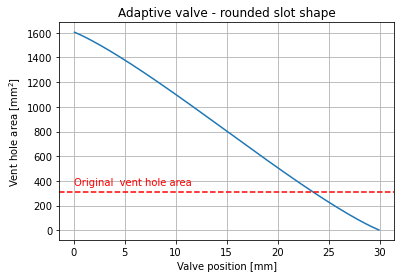

In [7]:
fig, valve_dispacement = plt.subplots() # create a plot
if slot_width > 0:
    title = 'rounded slot shape'
else:
    title = 'circle shape'
valve_dispacement.set_title('Adaptive valve - ' + title)
valve_dispacement.set_xlabel('Valve position [mm]')
valve_dispacement.set_ylabel('Vent hole area [mm$^{2}$]')
valve_dispacement.text(0, original_vent_hole_area + 50, 'Original  vent hole area', color='red')
valve_dispacement.grid()
valve_dispacement.plot(val_pos, valve_data) # plot computed data
plt.axhline(original_vent_hole_area, color='red',ls='--')
plt.show()

### Check vent hooles spacing

In [8]:
# INPUT
valve_width = 100 # [mm] set sliding valve width
horizontal_edge_spacing = 15 # [mm]
vertical_edge_spacing =  2 #[mm]
vent_hole_spacing = 55 # [mm] data for 1:2 scale design
actuatior_displacement_limit = 50 #[mm]

In [9]:
# calcultions
slot_height = 2*r

# find nearest value of valve displacement to match the oryginal vent hole area 
index = (np.abs(valve_data - original_vent_hole_area)).argmin()
# determine required displacement for valve
valve_position_limit = round(val_pos[index])

print('CHECK VALVE DESIGN REQUIREMENT:')
print('- Required horizontal displacement for valve {} mm'.format(valve_position_limit))

# check if dispacement limit is not exceded
if actuatior_displacement_limit >= valve_position_limit:
    print('- Required valve displacement within actuator limit')
else:
    print('''- Required valve displacement exceded {} mm!
    Consider different vent hole shape or change of actuator'''
          .format(abs(actuatior_displacement_limit - valve_position_limit)))

# chceck vent hole horizontal spacing
if (vent_hole_spacing - 2*r -valve_position_limit - vertical_edge_spacing) >= 0:
    print('- Valve horizontal spacing ok')
else:
    print("""- Valve horizontal spacing exceded of: {} mm!
    Reduce 'r'"""
          .format(abs(vent_hole_spacing - 2*r -valve_position_limit - vertical_edge_spacing)))
   
# chceck vent hole vertical spacing
if (valve_width - 2*horizontal_edge_spacing) >= (2*r + slot_width):
    print('- Valve width ok')
else:
    print("""- Valve width exceded of: {} mm!
    Reduce 'slot_width' or 'r"""
          .format((2*r + slot_width) - (valve_width - 2*horizontal_edge_spacing)))

CHECK VALVE DESIGN REQUIREMENT:
- Required horizontal displacement for valve 23 mm
- Required valve displacement within actuator limit
- Valve horizontal spacing ok
- Valve width ok


# Experimental results for adaptive air caution

### Impact absorption of the air cushion - opening of valves 1:4

In [10]:
# set file path
file_name = 'zrzut_m10kg_h3500_v1-4_1.txt'
data_dir = 'Pomiary/SkokochronAdaptacyjny/'
crio_data_dir = Path(data_dir, 'data_crio/')
shimmer_data_dir = Path(data_dir, 'data_shimmer/')

# load data from c-rio
crio_data = pd.read_csv(Path(crio_data_dir, file_name), sep='\t', header = None)
crio_data.drop([0, 10], axis = 1, inplace=True)
crio_data.columns = ['Top chamber pressure', 'Bottom chamber pressure','Air frame pressure',\
                     'Absolute pressure', 'Force 1', 'Force 2',\
                     'Force 3', 'Force 4', 'Sum of forces']
crio_data.head()

,Top chamber pressure,Bottom chamber pressure,Air frame pressure,Absolute pressure,Force 1,Force 2,Force 3,Force 4,Sum of forces
0,-0.164356,0.274846,146.752987,993.343003,65.131911,315.935403,5221.493786,75.123595,5677.684694
1,1.600660,-0.960666,147.327551,994.697589,62.901900,311.669308,5221.493786,70.214512,5666.279506
2,-0.234136,0.061402,145.932182,995.846935,64.972624,312.775333,5221.493786,74.015092,5673.256834
3,0.147600,0.172228,145.193457,994.410253,65.450484,313.565350,5221.493786,73.856735,5674.366354
4,1.391321,-0.981189,146.999229,994.205013,63.698332,311.669308,5221.493786,71.639730,5668.501156


In [11]:
# load data from shimmer
shimmer_data = pd.read_csv(Path(shimmer_data_dir, file_name), sep='\t')
shimmer_data.head()

,Timestamp,PC Timestamp,Low Noise Accelerometer X,Low Noise Accelerometer Y,Low Noise Accelerometer Z,Int A12,Int A13,Int A14,Gyroscope X,Gyroscope Y,Gyroscope Z,Wide Range Accelerometer X,Wide Range Accelerometer Y,Wide Range Accelerometer Z
0,144075.287,NaN,-5.815,2.457,20.957,1504.029,1501.099,1495.971,-2.626,0.916,3.359,-0.383,-1.148,-9.263
1,144076.263,NaN,-5.837,2.457,20.967,1504.029,1501.099,1495.971,-2.595,0.962,3.389,-0.383,-1.072,-9.416
2,144077.240,NaN,-5.826,2.489,20.946,1503.297,1500.366,1493.040,-2.733,0.947,3.496,-0.306,-1.148,-9.569
3,144078.217,NaN,-5.826,2.478,20.978,1505.495,1501.099,1495.971,-2.611,0.855,3.542,-0.383,-1.072,-9.340
4,144079.193,NaN,-5.804,2.467,20.978,1504.029,1501.099,1495.238,-2.244,0.931,3.573,-0.306,-1.148,-9.493


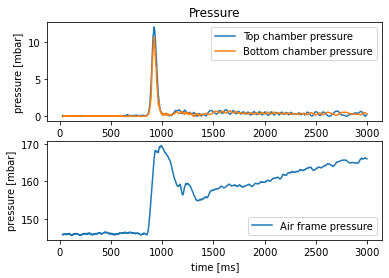

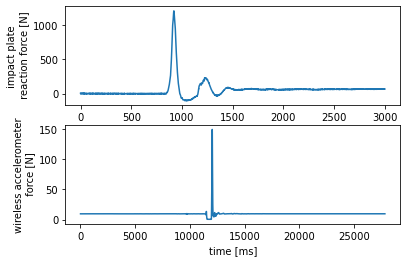

In [12]:
data_range = 3000 # select number of samples to be processed

def sync_force(plate_reaction_force, wireless_accel_force, data_range = 2000):
    plate_peak_index = plate_reaction_force
    wireless_accel_peak_index =  
    return synchronized_vect

# proces and plot pressures 
fig, axes = plt.subplots(nrows=2, ncols=1)
chamber_pressure = crio_data.iloc[:data_range, 0:2].rolling(30).mean()
chamber_pressure.plot.line(title = 'Pressure', ylabel = 'pressure [mbar]',\
                                     ax=axes[0])
air_frame_pressure = crio_data.iloc[:data_range, 2:3].rolling(30).mean()
air_frame_pressure.plot.line(xlabel = 'time [ms]', ylabel = 'pressure [mbar]',\
                                     ax=axes[1])
plt.show()
# proces and plot forces 
fig, axes = plt.subplots(nrows=2, ncols=1)
impact_plate_reaction_force = crio_data.iloc[:data_range, 4:-2].sum(axis=1)
force_offset = impact_plate_reaction_force.iloc[:500].mean()
impact_plate_reaction_force = impact_plate_reaction_force.subtract(force_offset)
impact_plate_reaction_force.plot.line(ylabel = 'impact plate\n reaction force [N]', ax=axes[0])
shimmer_force = np.sqrt(np.sum(np.power(shimmer_data.iloc[:,-3:], 2), axis=1))
shimmer_force = shimmer_force.rolling(30).mean()
shimmer_force.plot.line(xlabel = 'time [ms]', ylabel = 'wireless accelerometer\n force [N]', ax=axes[1])
plt.show()

In [13]:
movie_title = file_name[:-3]+'mp4'
movie_path = Path(data_dir, 'movies', movie_title)
Video(movie_path, width=600, height=480)

### Impact absorption of the air cushion - opening of valves 1/1

In [14]:
# set file path
file_name = 'zrzut_m10kg_h3500_v1-1_2.txt'
data_dir = 'Pomiary/SkokochronAdaptacyjny/'
crio_data_dir = Path(data_dir, 'data_crio/')
shimmer_data_dir = Path(data_dir, 'data_shimmer/')

# load data from c-rio
crio_data = pd.read_csv(Path(crio_data_dir, file_name), sep='\t', header = None)
crio_data.drop([0, 10], axis = 1, inplace=True)
crio_data.columns = ['Top chamber pressure', 'Bottom chamber pressure','Air frame pressure',\
                     'Absolute pressure', 'Force 1', 'Force 2',\
                     'Force 3', 'Force 4', 'Sum of forces']
crio_data.head()

,Top chamber pressure,Bottom chamber pressure,Air frame pressure,Absolute pressure,Force 1,Force 2,Force 3,Force 4,Sum of forces
0,-0.271078,0.266636,166.041912,993.219859,72.459090,303.453126,5221.493786,81.774610,5679.180611
1,1.493938,-0.964770,166.041912,994.328157,69.114073,303.295123,5221.493786,78.290745,5672.193726
2,-0.180775,0.106553,163.989898,995.600646,71.184798,304.243144,5221.493786,82.408040,5679.329767
3,0.131182,0.196857,165.139026,994.738637,70.388365,304.875158,5221.493786,81.457895,5678.215203
4,1.612974,-0.275183,164.974865,994.574445,68.954786,305.191165,5221.493786,78.765817,5674.405554


In [15]:
# load data from shimmer
shimmer_data = pd.read_csv(Path(shimmer_data_dir, file_name), sep='\t')
shimmer_data.head()

,Timestamp,PC Timestamp,Low Noise Accelerometer X,Low Noise Accelerometer Y,Low Noise Accelerometer Z,Int A12,Int A13,Int A14,Gyroscope X,Gyroscope Y,Gyroscope Z,Wide Range Accelerometer X,Wide Range Accelerometer Y,Wide Range Accelerometer Z
0,186938.080,NaN,-6.098,2.337,20.935,1503.297,1499.634,1496.703,-0.992,0.290,-1.863,-0.459,-1.148,-9.493
1,186939.056,NaN,-5.696,2.370,21.130,1504.029,1499.634,1495.971,-0.901,0.229,-1.771,-0.077,-1.301,-9.263
2,186940.033,NaN,-5.989,2.370,20.989,1505.495,1500.366,1497.436,-1.145,0.260,-1.725,-0.383,-1.301,-9.416
3,186941.010,NaN,-5.989,2.326,20.859,1504.029,1500.366,1495.238,-1.115,0.290,-1.588,-0.459,-1.378,-9.263
4,186941.986,NaN,-6.033,2.304,21.033,1503.297,1500.366,1495.238,-1.008,0.321,-1.496,-0.842,-1.301,-9.493


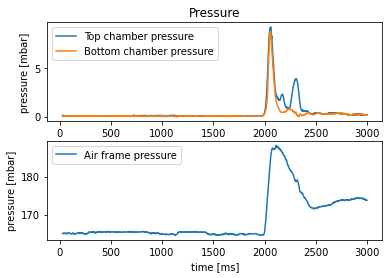

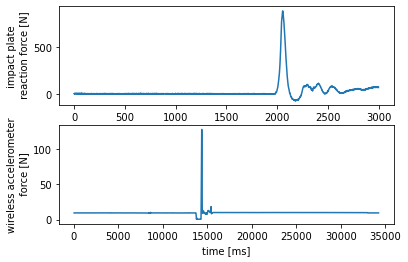

In [16]:
data_range = 3000 # select number of samples to be processed

# proces and plot pressures 
fig, axes = plt.subplots(nrows=2, ncols=1)
chamber_pressure = crio_data.iloc[:data_range, 0:2].rolling(30).mean()
chamber_pressure.plot.line(title = 'Pressure', ylabel = 'pressure [mbar]',\
                                     ax=axes[0])
air_frame_pressure = crio_data.iloc[:data_range, 2:3].rolling(30).mean()
air_frame_pressure.plot.line(xlabel = 'time [ms]', ylabel = 'pressure [mbar]',\
                                     ax=axes[1])
plt.show()
# proces and plot forces 
fig, axes = plt.subplots(nrows=2, ncols=1)
impact_plate_reaction_force = crio_data.iloc[:data_range, 4:-2].sum(axis=1)
force_offset = impact_plate_reaction_force.iloc[:500].mean()
impact_plate_reaction_force = impact_plate_reaction_force.subtract(force_offset)
impact_plate_reaction_force.plot.line(ylabel = 'impact plate\n reaction force [N]', ax=axes[0])
shimmer_force = np.sqrt(np.sum(np.power(shimmer_data.iloc[:,-3:], 2), axis=1))
shimmer_force = shimmer_force.rolling(30).mean()
shimmer_force.plot.line(xlabel = 'time [ms]', ylabel = 'wireless accelerometer\n force [N]', ax=axes[1])
plt.show()

In [17]:
movie_title = file_name[:-3]+'mp4'
movie_path = Path(data_dir, 'movies', movie_title)
Video(movie_path, width=600, height=480)